# SentencePiece
---

SentencePiece 사용하여 감정분석을 해보자 ( ᐛ )و

## STEP 0. 설계
---

SentencePiece가 무엇인지 알아보고, SentencePiece와 네이버 영화리뷰 데이터를 이용하여 Sentiment Analysis를 진행하여 본다.
1. SentencePiece란
    - SentencePiece란 무엇인가?
    - Tokenizer 비교
2. SentencePiece와 한국어 Tokenizer
    - [korean-english-news-v1](https://github.com/jungyeul/korean-parallel-corpora/tree/master/korean-english-news-v1) 데이터를 활용하여  SentencePiece를 학습시킨다.
    - 학습된 모델의 동작을 테스트 한다.
    - 위에서 훈련시킨  SentencePiece를 활용하여 문장을 토큰화 시키는 함수를 작성한다.
    - 성능비교를 위하여 Mecab와 Khahiii를 활용한 Tokenizer 함수 역시 작성한다.
4. Sentiment Analysis - 1. 데이터 전처리
    - 데이터 불러오기
    - 데이터 로더 구성 : 데이터 로더는 다음과 같은 기능을 수행해야 한다.
        - 데이터의 중복 제거
        - NaN 결측치 제거
        - 한국어 토크나이저로 토큰화
        - X_train, y_train, X_test, y_test, tokenizer class(SPTockenizer, KhaiiiTocknizer, MecabTockenizer) 반환
    - 데이터 분석 및 가공
        - 데이터셋의 길이 분포 확인
        - 적절한 문장 최대 길이 지정
        - 문장에 패딩 추가 및 문장길이 제한
        - validation set 분리
5. Sentiment Analysis - 2. 모델 정의
    - LSTM 레이를 사용하는 모델을 정의한다.
    - 모델을 정의하여 반환해주는 함수를 작성하여 재사용이 용이하도록 해둔다.
6. Sentiment Analysis - 3. 모델 학습
    - 4에서 생성한 세가지 데이터셋에 대하여 각각 모델학습을 수행한다. 
7. Sentiment Analysis - 4. 모델 평가
    - 6에서 학습시킨 모델을 평가해보고 학습데이터에 따른 성능차이를 확인해 본다.
8. 추가실험
    - SentencePiece 모델 학습에는 다양한 파라미터가 활용된다. 이들을 변경해가면 모델을 개선시켜 보자.
9. 결론

#### environment setting

- import packages

In [1]:
import os

import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import pickle
from functools import reduce
import pandas as pd

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

- set workspace path

In [2]:
!pwd

/home/aiffel-dj1/workspace/aiffel-gd-nlp/GD02_sp_tokenizer


In [3]:
workspace_path = os.getenv('HOME')+'/workspace/aiffel-gd-nlp/GD02_sp_tokenizer'
data_dir_path = workspace_path + '/data'
tokenizer_path = workspace_path + '/tokenizer'

- init gpu

In [4]:
def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs\n\n")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e, "\n\n")
        
init_gpu()

1 Physical GPUs, 1 Logical GPUs




## STEP 1. SentencePiece
---

### 1. Tokenization

- 말뭉치(Corpus) : 자연어 연구를 위해 특정한 목적을 가지고 추출한 언어의 표본 집합, 텍스트 표본
- 토큰(Token) : 문법적으로 더 이상 나눌 수 없는 언어요소
- 텍스트 토큰화(Text Tokenization) : 말뭉치들을 토큰으로 분리하는 작업
    - ex 1 : "그녀는 나와 밥을 먹는다" ➝ "그녀는", "나와", "밥을", "먹는다" / "그녀", "는", "나", "와", "밥", "을", "먹는다"
    - ex 2 : "There is an apple" ➝ "There", "is", "an", "apple"    

#### 텍스트 토큰화 분류
- 문장 토큰화
    - 문서를 마침표(.), 개행문자(\n), 느낌표(!), 물음표(?)과 같은 문자의 마지막을 뜻하는 기호를 기준으로 분리하는 것
    - 문서 ➝ 문장
    - ex : "What time is it now? It is a quarter past nine by my watch." ➝ "What time is it now?", "It is a quarter past nine by my watch."
- 단어 토큰화
    - 문장을 띄어씌기, 마침표(.), 쉼표(,), 작은따옴표(어퍼스트로피, ') 등을 기준으로하여 단어로 분리하는 것. 
    - 대체적으로 띄어쓰기를 기본으로 한다. 영어에서는 이 방법론이 잘 작동하나 한국어의 경우에는 띄어쓰기 만으로는 토큰 구분이 어려울 수 있다.
    - 문장 ➝ 단어
    - ex : "Don't be fooled by the dark sounding name, Mr. Jone's Orphanage is as cheery as cheery goes for a pastry shop." ➝ "Don", "'", "t", "be", "fooled", "by", "the", "dark", "sounding", "name", ",", "Mr", ".", "Jone", "'", "s", "Orphanage", "is", "as", "cheery", "as", "cheery", "goes", "for", "a", "pastry", "shop", "."]
- 형태소 기반 토큰화
    - ![영어형태소](https://ifh.cc/g/Bg0UZq.jpg)
    - 한국어 뿐만 아니라 영어도 단어를 형태소로 분리하는 것이 가능하다.
    - 형태소 기반 토큰화가 공백 기반 토큰화와 비교하여 단어 사전의 크기가 줄어든다는 이점을 가지고 이는 연산량 감소, 학습 시간 단축, 모델의 파라미터 수 감소로 이어진다.
    - 문장 ➝ 단어 ➝ 형태소

In [361]:
# 형태소 기반 토큰화 예시 1 : 영문
from nltk.tokendize import word_tokenize
from nltk.tag import pos_tag

text = "Don't be fooled by the dark sounding name, Mr. Jone's Orphanage is as cheery as cheery goes for a pastry shop."
x = word_tokenize(text)
pos_tag(x)

[('Do', 'VBP'),
 ("n't", 'RB'),
 ('be', 'VB'),
 ('fooled', 'VBN'),
 ('by', 'IN'),
 ('the', 'DT'),
 ('dark', 'NN'),
 ('sounding', 'VBG'),
 ('name', 'NN'),
 (',', ','),
 ('Mr.', 'NNP'),
 ('Jone', 'NNP'),
 ("'s", 'POS'),
 ('Orphanage', 'NN'),
 ('is', 'VBZ'),
 ('as', 'RB'),
 ('cheery', 'JJ'),
 ('as', 'IN'),
 ('cheery', 'NN'),
 ('goes', 'VBZ'),
 ('for', 'IN'),
 ('a', 'DT'),
 ('pastry', 'NN'),
 ('shop', 'NN'),
 ('.', '.')]

In [363]:
# 형태소 기반 토큰화 예시 2 : 한글
from konlpy.tag import Okt  
okt = Okt()  
print(okt.pos("그녀는 나와 밥을 먹는다."))  

[('그녀', 'Noun'), ('는', 'Josa'), ('나와', 'Verb'), ('밥', 'Noun'), ('을', 'Josa'), ('먹는다', 'Verb'), ('.', 'Punctuation')]


- 서브워드 토큰화(Subword Tokenization)
    - 이전의 토큰화들은 OOV 문제에 대하여 취약하다. 서브워드 토큰화는 하나의 단어가 의미있는 작은 단어의 조합(birthplace = birth + place)라는 점을 착안하여, 하나의 단어를 여러개의 서브워브(subword)로 분리하여 토큰화를 진행한다.
    - 서브워드 토큰화는 OOV 문제를 개선할 수 있으며, 띄워쓰기 실수와 오타에 강건하다는 특징을 가진다.
    - 서브워드 알고리즘
        - BPE(Byte Pair Encoding)
            - ![bpe](https://ifh.cc/g/mN6AtZ.png)
            - BPE는 데이터를 압축하기 위한 알고리즘으로 데이터에서 가장 많이 등장하는 바이트 쌍(Byte Pair)을 하나의 새로운 단어로 압축하는 작업을 반복하는 방식으로 동작한다.
            - ex
                - ![bpe_example](https://ifh.cc/g/sY8dVL.png)
        - Unigram
            - Unigram은 각각의 서브워드들에 대해서 손실(해당 서브워드가 단어 집합에서 제거되었을 경우, 코퍼스의 우도(Likelihood)가 감소하는 정도)을 계산한다. 그리고 서브워드들을 손실의 정도로 정렬하여, 상위 η% 만큼의 subword만을 유지한다. 이를 원하는 단어 집합의 크기에 도달할 때까지 반복한다.
        - Wordpiece
            - BPE 변형 알고리즘
            - 공백 복원을 위하여 단어의 시작 부분에 언더바(\_)를 추가한다.
            - BPE가 빈도수에 기반하여 가장 많이 등장한 쌍을 병합하는 것과는 달리, 병합되었을 때 코퍼스의 우도(Likelihood)를 가장 높이는 쌍을 병합한다.
            - ex 
                - raw : Jet makers feud over seat width with big orders at stake
                - wordpieces : \_J et \_makers \_fe ud \_over \_seat \_width \_with \_big \_orders \_at \_stake
    - SentencePiece
        - 구글에서 제공하는 Subword Tokenization 패키지.
        - BPE와 Unigram 알고리즘을 포함하고 있다.

### 2. 한국어 Tokenizer

- 한국어 토큰화에는 주로 subword 방식과 형태소 분석 방식이 많이 사용된다.
- 그 중 공개된 패키지를 기반으로 사용가능 Tokenizer는 다음과 같다.

| subword | Morphology | 
| :-------:|:-----------:|
| BPE<br>Uingram<br>WordPiece | Khaiii<br>Hannanum<br>Kkma<br>Komoran<br>Mecab<br>Okt |

- BPE와 Unigram은 Google에서 제공하는 SentencePiece 패키지를 통해 사용이 가능하다.
- WordPiece는 [huggingface의 tokenizers 패키지](https://github.com/huggingface/tokenizers)를 통해 사용이 가능하다.
- Hannanum, Kkma, Komoran, Mecab, Okt는 KoNLPy 패키지를 통해 사용이 가능하다.
- Khaiii는 [github 저장소](https://github.com/kakao/khaiii)에서 설치 후 사용이 가능하다.

## STEP 2. SentencePiece와 한국어 Tokenizer
---

SentencePiece를 학습시키고 테스트해보자.

### 1. 학습 데이터 다운로드 및 분석

#### 1) 데이터 다운로드
- [jungyeul/korean-parallel-corpora](https://github.com/jungyeul/korean-parallel-corpora)에 공개된 한국어-영어 병렬 말뭉치 다운로드

In [ ]:
# ! wget https://github.com/jungyeul/korean-parallel-corpora/raw/master/korean-english-news-v1/korean-english-park.train.tar.gz -P ./data
# ! tar -xzvf ./data/korean-english-park.train.tar.gz -C ./data

In [5]:
! ls ./data

korean-english-park.train.en  korean-english-park.train.ko.temp
korean-english-park.train.ko  korean-english-park.train.tar.gz


- 데이터 확인

In [5]:
sp_train_data_path = data_dir_path + '/korean-english-park.train.ko'

In [48]:
with open(sp_train_data_path, "r") as f:
    sp_train_data_raw = f.read().splitlines()

In [49]:
print(f'Data Size : {len(sp_train_data_raw)}')
print("Example:")
for sen in sp_train_data_raw[100:200][::20]: print(">>", sen)

Data Size : 94123
Example:
>> 제 23차 연례 컴덱스 박람회의 개회사를 한 케이츠는 2년여전 기술 산업의 거품이 붕괴된 이후에 첨단 기술에 대해 부정적인 인식이 있다고 말했다.
>> "미국은 상업 활동의 역사가 수백년이지만, 한국은 얼마 되지 않습니다."
>> 그리고 홍콩과 싱가폴은 보다 자율적인 과정에따라 그러한 방향으로 완화시켜 나가고 있다.
>> 미국의 빌 클린턴 대통령은 1967년 하노이 외곽에서 격추된 美 F-105D機의 추락 장소를 방문한 후에 베트남의 호치민 시에 도착했다.
>> 이것은 사람의 발이 하는 일을 하는 타이어를 갖고 있습니다."


#### 2) 중복 제거

In [50]:
print(f'Data Size - before remove duplication : {len(sp_train_data_raw)}')
sp_train_data_raw = list(set(sp_train_data_raw))
print(f'Data Size - after remove duplication : {len(sp_train_data_raw)}')

Data Size - before remove duplication : 94123
Data Size - after remove duplication : 77591


#### 3) 문장길이 지정
- 문장 길이 분포 확인

In [6]:
def check_sentence_len_distribution(data):
    lengths = []
    min_len = 999
    max_len = 0
    sum_len = 0

    for sen in data:
        length = len(sen)
        min_len = min(length, min_len)
        max_len = max(length, max_len)
        sum_len += length
        lengths.append(length)

    print(f'min sentence length : {min_len}')
    print(f'max sentence length : {max_len}')
    print(f'avg sentence length : {sum_len // len(data)}')

    hist, bins = np.histogram(lengths, range(0, max_len+1))
    hist = np.insert(hist, 0, 0, axis=0)

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    axes[0].set_title("Sentence Length Distribution")
    axes[0].bar(bins, hist, width=1.0)
    axes[0].set_xticks(np.arange(0, max_len, 20), minor=True)
    axes[0].grid(which='minor', alpha=0.4)
    axes[0].grid(which='major', alpha=0.7)
    
    axes[1].boxplot(lengths)
    axes[1].set_title("Sentence Length Distribution")
    axes[1].grid(which='minor', alpha=0.4, axis='y')
    axes[1].grid(which='major', alpha=0.7, axis='y')

    plt.show()
    
    return hist

min sentence length : 1
max sentence length : 377
avg sentence length : 64


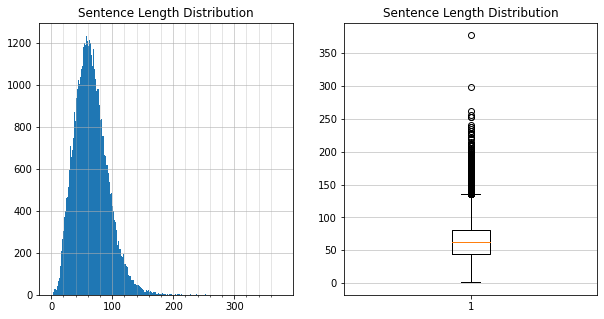

In [52]:
length_hist = check_sentence_len_distribution(sp_train_data_raw)

주어진 데이터의 최소 길이는 1, 최대 길이는 377, 평균길이는 64이다.<br>
bar 그래프를 보았을때, 대체적으로 10 이상 150 이하의 길이를 가지고 있다.<br>
문장길이의 범위를 지정하기 위해 좀 더 통계적인 방법으로 문장의 분포를 확인해보자.

- 문장 길이 선정을 위한 통계적 확인

In [7]:
def rate_under_lenght_threshold(length_hist, threshole):
    cnt = sum(length_hist[2:threshole+2])
    total = sum(length_hist)
    print(f'rate of sentences {threshole} or less in length : {cnt / total}')

In [13]:
rate_under_lenght_threshold(length_hist, 10)
rate_under_lenght_threshold(length_hist, 15)
rate_under_lenght_threshold(length_hist, 30)
rate_under_lenght_threshold(length_hist, 45)
rate_under_lenght_threshold(length_hist, 60)

rate of sentences 10 or less in length : 0.0034668969339227487
rate of sentences 15 or less in length : 0.010735781211738476
rate of sentences 30 or less in length : 0.09020376074544728
rate of sentences 45 or less in length : 0.2553775566753876
rate of sentences 60 or less in length : 0.4755190679331366


문장의 최소 길이는 10으로 두는 것이 적절해 보인다.

In [14]:
rate_under_lenght_threshold(length_hist, 100)
rate_under_lenght_threshold(length_hist, 125)
rate_under_lenght_threshold(length_hist, 150)
rate_under_lenght_threshold(length_hist, 175)
rate_under_lenght_threshold(length_hist, 200)

rate of sentences 100 or less in length : 0.904189918933897
rate of sentences 125 or less in length : 0.9763116856336431
rate of sentences 150 or less in length : 0.9940328130839917
rate of sentences 175 or less in length : 0.9985436455258986
rate of sentences 200 or less in length : 0.999600469126574


문장의 최대 길이는 150이 적절해 보인다.

In [15]:
sp_train_data_max_length = 150
sp_train_data_min_length = 10

- 조건에 맞는 문장으로 필터링

In [16]:
sp_train_data_filtered = [s for s in sp_train_data_raw if (len(s) <= sp_train_data_max_length) & (len(s) >= sp_train_data_min_length)]

min sentence length : 10
max sentence length : 150
avg sentence length : 64


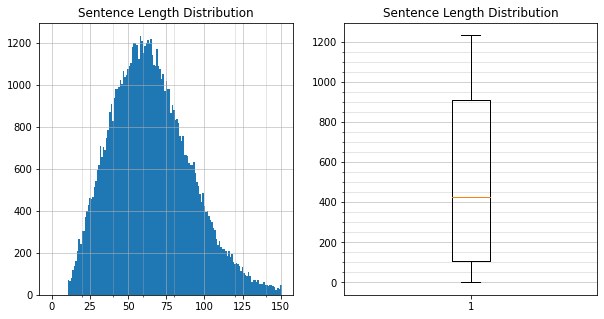

In [17]:
_ = check_sentence_len_distribution(sp_train_data_filtered)

#### 4) 저장
SentencePiece를 학습시키는 함수 *Train*은 인자로 input 데이터의 경로를 받기 때문에, 정제된 말뭉치 데이터를 로컬에 저장하고 그 주소를 변수에 저장한다.

In [8]:
sp_train_data_path = data_dir_path + '/korean-english-park.train.ko.temp'

In [19]:
with open(sp_train_data_path, 'w') as f:
    for row in sp_train_data_filtered:
        f.write(str(row) + '\n')

In [20]:
!ls ./data

korean-english-park.train.en  korean-english-park.train.ko.temp
korean-english-park.train.ko  korean-english-park.train.tar.gz


### 2. SentencePiece 모델 학습

In [8]:
import sentencepiece as spm

In [9]:
vocab_size = 10000

In [23]:
spm.SentencePieceTrainer.Train(
    f'--input={sp_train_data_path} --model_prefix=korean_spm --vocab_size={vocab_size}')

In [24]:
!mv korean_spm.model ./tokenizer/korean_spm.model
!mv korean_spm.vocab ./tokenizer/korean_spm.vocab

In [25]:
!ls ./tokenizer/

khaiii.vocab  korean_spm.model	korean_spm.vocab  mecab.vocab


### 3. 학습된 SentencePiece 모델 테스트

In [7]:
s = spm.SentencePieceProcessor()
s.Load(tokenizer_path + '/korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds('아버지가방에들어가신다.')
print(f'encoded : {tokensIDs}')

# SentencePiece를 활용한 sentence -> encoded pieces
print(f'encoded pieces : {s.SampleEncodeAsPieces("아버지가방에들어가신다.",1, 0.0)}')

# SentencePiece를 활용한 encoding -> sentence 복원
print(f'decoded : {s.DecodeIds(tokensIDs)}')

encoded : [1161, 11, 408, 7, 3375, 11, 291, 38, 3]
encoded pieces : ['▁아버지', '가', '방', '에', '들어', '가', '신', '다', '.']
decoded : 아버지가방에들어가신다.


### 4. Tokenizer 함수 정의

SentencePiece, Khaiii, Mecab를 사용하여 토큰화를 진행하는 함수와 디코딩을 위한 함수를 작성한다.<br>
토큰화 함수는 다음과 같은 형식으로 정의되어야 한다.
```python
def tokenize(tokenizer, corpus):
    """
    1. Tokenize the corpus
    2. Encode the tokenized corpus
    
    args:
        tokenizer : tokenize model. SentencePiece. Khaiii, Mecab
        corpus : list of corpus
    return
        tensor : encoded corpus
        word_index : { <word> : <idx> }
        index_word : { <idx> : <word> }
    """
    
    # Tokenize the corpus
    # Encode the tokenized corpus
    
    return tensor, word_index, index_word
```

#### 1) SentencePiece
📋 정의

In [10]:
import sentencepiece as spm

class SPTockenizer():
    def __init__(self):
        self._s = spm.SentencePieceProcessor()
        self.vocab = None
        self.word_index = {}
        self.index_word = {}
        
    def _load_vocab(self, path):
        with open(f"{path}.vocab", 'r') as f:
            self.vocab = f.readlines()
            
    def _set_w2i_i2w(self):
        for idx, line in enumerate(self.vocab):
            word = line.split("\t")[0]
            self.index_word.update({idx : word})
            self.word_index.update({word: idx})
            
    def train(self, corpus, prefix='spm', vocab_size=10000, model_type='unigram'):
        # save corpus for training
        data_path = f'{data_dir_path}/sp_train_corpus.temp'
        with open(data_path, 'w') as f:
            for row in corpus:
                f.write(str(row) + '\n')
                
        spm.SentencePieceTrainer.Train(
            f'--input={data_path} --model_prefix={prefix} --vocab_size={vocab_size} --model_type={model_type}')
        
        self._load_vocab(f'{workspace_path}/{prefix}')
        self._set_w2i_i2w()
        self._s.Load(f'{workspace_path}/{prefix}.model')
    
    def tokenize(self, corpus, prefix='spm', vocab_size=10000, model_type='unigram'):
        self.train(corpus, prefix, vocab_size, model_type)
        
        tensor = []
        for sen in corpus:
            tensor.append(self._s.EncodeAsIds(sen))
            
        return tensor, self.word_index, self.index_word

    def encode(self, sentence):
        return self._s.EncodeAsIds(sentence)

    def decode(self, encoded):
        if type(encoded) == np.ndarray:
            encoded = encoded.tolist()
        
        # remove padding
        idx = -1
        for i, e in enumerate(encoded):
            if e != 0:
                idx = i
                break
        encoded = encoded[idx:]
        
        return self._s.DecodeIds(encoded)

📋 테스트

In [166]:
sp_tokenizer = SPTockenizer()

- tokenize

In [167]:
with open(sp_train_data_path, "r") as f:
    sp_train_data_raw = f.read().splitlines()

In [168]:
tensor, sp_word_index, sp_index_word = sp_tokenizer.tokenize(sp_train_data_raw, prefix='spt_test')

In [169]:
len(sp_index_word), len(sp_index_word)

(10000, 10000)

- decoding

In [170]:
print(f'raw data : {sp_train_data_raw[0]}')
print(f'encoded : {tensor[0]}')
print(f'decoded : {sp_tokenizer.decode(tensor[0])}')

raw data : 마이클 맥코넬 해군 제독은 상원법사위에서 알카에다가 크나큰 위협을 하고 있다고 말했다.
encoded : [1663, 1178, 302, 3927, 1768, 192, 1134, 12, 1146, 359, 81, 260, 15, 1111, 11, 1686, 69, 8962, 665, 5, 446, 83, 34, 3]
decoded : 마이클 맥코넬 해군 제독은 상원법사위에서 알카에다가 크나큰 위협을 하고 있다고 말했다.


- vocab

In [172]:
for idx in tensor[0]:
    print(f'idx({idx}) : {sp_index_word[idx]}')

idx(1663) : ▁마이클
idx(1178) : ▁맥
idx(302) : 코
idx(3927) : 넬
idx(1768) : ▁해군
idx(192) : ▁제
idx(1134) : 독
idx(12) : 은
idx(1146) : ▁상원
idx(359) : 법
idx(81) : 사
idx(260) : 위
idx(15) : 에서
idx(1111) : ▁알카에다
idx(11) : 가
idx(1686) : ▁크
idx(69) : 나
idx(8962) : 큰
idx(665) : ▁위협
idx(5) : 을
idx(446) : ▁하고
idx(83) : ▁있다고
idx(34) : ▁말했다
idx(3) : .


#### 2) Khaiii
📋 정의

In [12]:
import khaiii

class KhaiiiTocknizer():
    def __init__(self):
        self._kahiii = khaiii.KhaiiiApi()
        self._kahiii.open()
        self.tokenizer = None
        self.word_index = {}
        self.index_word = {}
        
    def _analyze(self, sen):
        res = []
        for word in self._kahiii.analyze(sen):
            for x in word.morphs:
                if x.tag not in ['SE', 'SO', 'SL', 'SH', 'SW', 'SN']:
                    res.append(x.lex)
        return " ".join(res)

    def set_vocab(self, corpus, vocab_size):
        morpheme = [self._analyze(sen) for sen in corpus ]
        
        self.tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size,
                                   filters="",
                                   oov_token='<unk>')
        self.tokenizer.fit_on_texts(morpheme)
        self.tokenizer.index_word.update({ 0 : '<pad>'})
        self.index_word = dict(filter(lambda e : e[0] <= vocab_size-1, self.tokenizer.index_word.items()))
        self.word_index = { w : i for i, w in self.index_word.items() }

    def tokenize(self, corpus, vocab_size=10000):
        self.set_vocab(corpus, vocab_size)
        tensor = [self._analyze(sen) for sen in corpus]
        tensor = self.tokenizer.texts_to_sequences(tensor)

        return tensor, self.word_index, self.index_word
    
    def encode(self, sentence):
        return self.tokenizer.texts_to_sequences([ self._analyze(sentence)])[0]
    
    def decode(self, encoded):
        if type(encoded) == np.ndarray:
            encoded = encoded.tolist()

            # remove padding
            idx = -1
            for i, e in enumerate(encoded):
                if e != 0:
                    idx = i
                    break
            encoded = encoded[idx:]

        return self.tokenizer.sequences_to_texts([encoded])[0]

📋 테스트

In [305]:
k_tokenizer = KhaiiiTocknizer()

- tokenize

In [306]:
with open(sp_train_data_path, "r") as f:
    sp_train_data_raw = f.read().splitlines()

In [307]:
tensor, k_word_index, k_index_word = k_tokenizer.tokenize(sp_train_data_raw)

In [308]:
len(k_word_index), len(k_index_word)

(10000, 10000)

- decoding

In [251]:
print(f'raw data : {sp_train_data_raw[0]}')
print(f'encoded : {tensor[0]}')
print(f'decoded : {k_tokenizer.decode(tensor[0])}')

raw data : 마이클 맥코넬 해군 제독은 상원법사위에서 알카에다가 크나큰 위협을 하고 있다고 말했다.
encoded : [1068, 7982, 1150, 272, 2379, 11, 1, 19, 1453, 1018, 1, 7, 429, 8, 2, 14, 18, 30, 40, 2, 12, 5, 4]
decoded : 마이클 맥코넬 해군 제 독 은 <unk> 에서 알카에 다가 <unk> ㄴ 위협 을 하 고 있 다고 말 하 였 다 .


- vocab

In [252]:
for idx in tensor[0]:
    print(f'idx({idx}) : {k_index_word[idx]}')

idx(1068) : 마이클
idx(7982) : 맥코넬
idx(1150) : 해군
idx(272) : 제
idx(2379) : 독
idx(11) : 은
idx(1) : <unk>
idx(19) : 에서
idx(1453) : 알카에
idx(1018) : 다가
idx(1) : <unk>
idx(7) : ㄴ
idx(429) : 위협
idx(8) : 을
idx(2) : 하
idx(14) : 고
idx(18) : 있
idx(30) : 다고
idx(40) : 말
idx(2) : 하
idx(12) : 였
idx(5) : 다
idx(4) : .


#### 3) Mecab
📋 정의

In [13]:
from konlpy.tag import Mecab

class MecabTockenizer():
    def __init__(self):
        self._mecab = Mecab()
        self.tokenizer = None
        self.word_index = {}
        self.index_word = {}
        
    def set_vocab(self, corpus, vocab_size):
        morpheme = [ " ".join(self._mecab.morphs(sen)) for sen in corpus ]
        self.tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size,
                                   filters="",
                                   oov_token='<unk>')
        self.tokenizer.fit_on_texts(morpheme)
        self.tokenizer.index_word.update({ 0 : '<pad>'})
        self.index_word = dict(filter(lambda e : e[0] <= vocab_size-1, self.tokenizer.index_word.items()))
        self.word_index = { w : i for i, w in self.index_word.items()}
    
    def tokenize(self, corpus, vocab_size=10000):
        self.set_vocab(corpus, vocab_size)
        tensor = [" ".join(self._mecab.morphs(sen)) for sen in corpus]
        tensor = self.tokenizer.texts_to_sequences(tensor)
        return tensor, self.word_index, self.index_word
    
    def encode(self, sentence):
        return self.tokenizer.texts_to_sequences([" ".join(self._mecab.morphs(sentence))])[0]
    
    def decode(self, encoded):
        if type(encoded) == np.ndarray:
            encoded = encoded.tolist()

            # remove padding
            idx = -1
            for i, e in enumerate(encoded):
                if e != 0:
                    idx = i
                    break
            encoded = encoded[idx:]

        return self.tokenizer.sequences_to_texts([encoded])[0]

📋 테스트

In [187]:
m_tokenizer = MecabTockenizer()

- tokenize

In [188]:
with open(sp_train_data_path, "r") as f:
    sp_train_data_raw = f.read().splitlines()

In [189]:
tensor, m_word_index, m_index_word = m_tokenizer.tokenize(sp_train_data_raw)

In [190]:
len(m_word_index), len(m_index_word)

(10000, 10000)

- decoding

In [191]:
print(f'raw data : {sp_train_data_raw[0]}')
print(f'encoded : {tensor[0]}')
print(f'decoded : {m_tokenizer.decode(tensor[0])}')

raw data : 마이클 맥코넬 해군 제독은 상원법사위에서 알카에다가 크나큰 위협을 하고 있다고 말했다.
encoded : [1089, 9614, 1205, 1, 9, 225, 426, 1, 17, 614, 16, 1, 461, 6, 11, 13, 14, 24, 35, 12, 3, 2]
decoded : 마이클 맥코넬 해군 <unk> 은 상원 법 <unk> 에서 알카에다 가 <unk> 위협 을 하 고 있 다고 말 했 다 .


- vocab

In [192]:
for idx in tensor[0]:
    print(f'idx({idx}) : {m_index_word[idx]}')

idx(1089) : 마이클
idx(9614) : 맥코넬
idx(1205) : 해군
idx(1) : <unk>
idx(9) : 은
idx(225) : 상원
idx(426) : 법
idx(1) : <unk>
idx(17) : 에서
idx(614) : 알카에다
idx(16) : 가
idx(1) : <unk>
idx(461) : 위협
idx(6) : 을
idx(11) : 하
idx(13) : 고
idx(14) : 있
idx(24) : 다고
idx(35) : 말
idx(12) : 했
idx(3) : 다
idx(2) : .


## STEP 4. Sentiment Analysis - 1. 데이터 전처리
---

### 1. 데이터 불러오기

- 한국어로 된 네이버 영화 리뷰 데이터를 [저장소](https://github.com/e9t/nsmc/)에서 다운로드 받는다.
- 이를 판다스로 불러들인다.

In [14]:
train_data = pd.read_table(data_dir_path + '/ratings_train.txt')
test_data  = pd.read_table(data_dir_path + '/ratings_test.txt')

In [15]:
train_data.head(5)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [16]:
test_data.head(5)

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


### 2. 데이터 로더 구성

#### 1) 데이터로더 정의

In [17]:
def load_data(train_data, test_data, Tokenizer, num_words=10000):
    # 1. 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    
    # 2. 결측치 제거
    train_data = train_data.dropna(how = 'any')
    test_data = test_data.dropna(how = 'any')
    
    # 3. 토큰화
    tokenizer = Tokenizer()
    X_train, word_index, index_word = tokenizer.tokenize(train_data['document'].to_list())
    X_test = [ tokenizer.encode(sen) for sen in test_data['document'].to_list() ]

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), tokenizer

In [18]:
class Dataset():
    def __init__(self, X_train, y_train, X_test, y_test, tokenizer):
        self.X_train = X_train
        self.y_train = y_train
        self.X_test = X_test
        self.y_test = y_test
        self.tokenizer = tokenizer
        self.X_val = None
        self.y_val = None

#### 2) 토큰화 - SentencePiece

In [19]:
X_train, y_train, X_test, y_test, sp_tokenizer = load_data(train_data,
                                                           test_data,
                                                           SPTockenizer)
sp_dataset = Dataset(X_train, y_train, X_test, y_test, sp_tokenizer)

In [17]:
print(f'X_train[0] : {sp_dataset.X_train[0]}')
print(f'X_train[0] - raw : {train_data.iloc[0]["document"]}')
print(f'X_train[0] - decoding : {sp_dataset.tokenizer.decode(X_train[0])}')
print(f'y_train[0] : {sp_dataset.y_train[0]}\n')

print(f'X_test[0] : {sp_dataset.X_test[0]}')
print(f'X_test[0] - raw : {test_data.iloc[0]["document"]}')
print(f'X_test[0] - decoding : {sp_dataset.tokenizer.decode(X_test[0])}')
print(f'y_test[0] : {sp_dataset.y_test[0]}')

X_train[0] : [61, 870, 5, 30, 2025, 66, 1720]
X_train[0] - raw : 아 더빙.. 진짜 짜증나네요 목소리
X_train[0] - decoding : 아 더빙.. 진짜 짜증나네요 목소리
y_train[0] : 0

X_test[0] : [2643, 275]
X_test[0] - raw : 굳 ㅋ
X_test[0] - decoding : 굳 ᄏ
y_test[0] : 1


#### 3)  토큰화 - Khaiii

In [18]:
X_train, y_train, X_test, y_test, k_tokenizer = load_data(train_data,
                                                           test_data,
                                                           KhaiiiTocknizer)

k_dataset = Dataset(X_train, y_train, X_test, y_test, k_tokenizer)

In [19]:
print(f'X_train[0] : {k_dataset.X_train[0]}')
print(f'X_train[0] - raw : {train_data.iloc[0]["document"]}')
print(f'X_train[0] - decoding : {k_dataset.tokenizer.decode(X_train[0])}')
print(f'y_train[0] : {k_dataset.y_train[0]}\n')

print(f'X_test[0] : {k_dataset.X_test[0]}')
print(f'X_test[0] - raw : {test_data.iloc[0]["document"]}')
print(f'X_test[0] - decoding : {k_dataset.tokenizer.decode(X_test[0])}')
print(f'y_test[0] : {k_dataset.y_test[0]}')

X_train[0] : [31, 92, 1748, 151, 76, 328, 1988, 82, 779]
X_train[0] - raw : 아 더빙.. 진짜 짜증나네요 목소리
X_train[0] - decoding : 아 더 빙 .. 진짜 짜증 나네 요 목소리
y_train[0] : 0

X_test[0] : [1241, 61]
X_test[0] - raw : 굳 ㅋ
X_test[0] - decoding : 굳 ㅋ
y_test[0] : 1


#### 4)  토큰화 - mecab

In [20]:
X_train, y_train, X_test, y_test, m_tokenizer = load_data(train_data,
                                                           test_data,
                                                           MecabTockenizer)
m_dataset = Dataset(X_train, y_train, X_test, y_test, m_tokenizer)

In [21]:
print(f'X_train[0] : {m_dataset.X_train[0]}')
print(f'X_train[0] - raw : {train_data.iloc[0]["document"]}')
print(f'X_train[0] - decoding : {m_dataset.tokenizer.decode(X_train[0])}')
print(f'y_train[0] : {m_dataset.y_train[0]}\n')

print(f'X_test[0] : {m_dataset.X_test[0]}')
print(f'X_test[0] - raw : {test_data.iloc[0]["document"]}')
print(f'X_test[0] - decoding : {m_dataset.tokenizer.decode(X_test[0])}')
print(f'y_test[0] : {m_dataset.y_test[0]}')

X_train[0] : [41, 86, 937, 2, 2, 48, 242, 28, 42, 765]
X_train[0] - raw : 아 더빙.. 진짜 짜증나네요 목소리
X_train[0] - decoding : 아 더 빙 . . 진짜 짜증 나 네요 목소리
y_train[0] : 0

X_test[0] : [850, 143]
X_test[0] - raw : 굳 ㅋ
X_test[0] - decoding : 굳 ㅋ
y_test[0] : 1


### 3. 데이터 분석 및 가공
#### 1) 데이터셋의 길이 분포 확인
너무 길이가 짧은 데이터 혹은 긴 데이터는 노이즈가 될 수 있으므로 적절한 값을 선정하여 길이에 제한을 주어야한다.

min sentence length : 1
max sentence length : 132
avg sentence length : 16


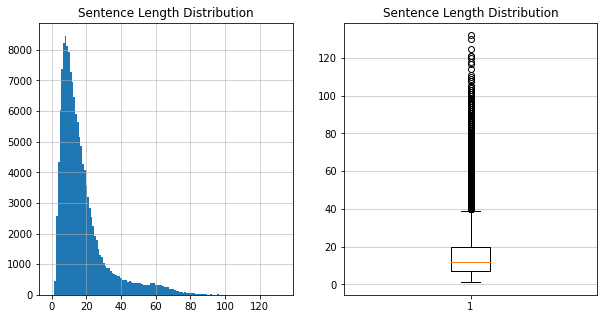

In [258]:
sp_length_hist = check_sentence_len_distribution(sp_dataset.X_train)

min sentence length : 0
max sentence length : 109
avg sentence length : 19


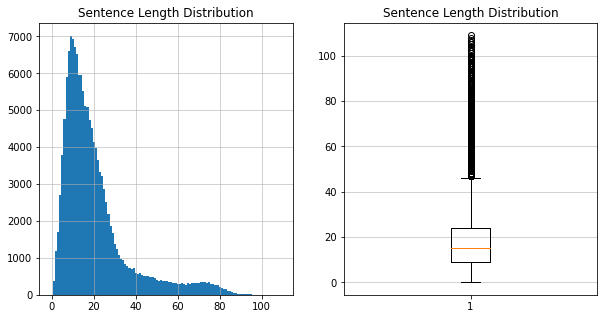

In [259]:
k_length_hist = check_sentence_len_distribution(k_dataset.X_train)

min sentence length : 1
max sentence length : 116
avg sentence length : 18


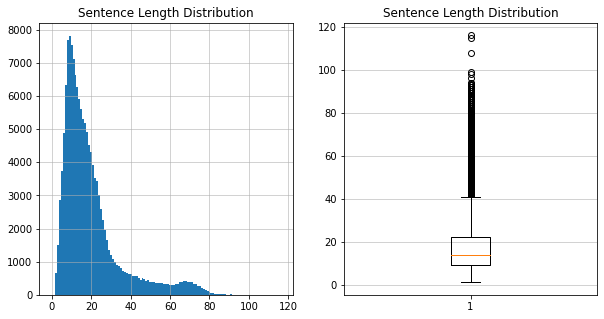

In [260]:
m_length_hist = check_sentence_len_distribution(m_dataset.X_train)

토큰화 된 데이터 최소/최대/평균 길이는 각각 (1/132/16), (0/109/19), (1/116/18)이다. <br>
bar 그래프로 보았을 때, 각 데이터의 길이는 대체로 1\~39, 0\~44, 1\~41 사이에 분포하여 있다.<br>
문장길이의 범위를 지정하기 위해 좀 더 통계적인 방법으로 문장의 분포를 확인해보자.

#### 2) 문장 길이 선정을 위한 통계적 확인

In [279]:
# sp
for threshold in range(48, 63, 3):
    rate_under_lenght_threshold(sp_length_hist, threshold)

rate of sentences 48 or less in length : 0.946505041660396
rate of sentences 51 or less in length : 0.9541940868232751
rate of sentences 54 or less in length : 0.9608638546469469
rate of sentences 57 or less in length : 0.9683818801220396
rate of sentences 60 or less in length : 0.9754689359839105


In [280]:
# khaiii
for threshold in range(48, 63, 3):
    rate_under_lenght_threshold(k_length_hist, threshold)

rate of sentences 48 or less in length : 0.9215430080310846
rate of sentences 51 or less in length : 0.9296014557195824
rate of sentences 54 or less in length : 0.9372426153698814
rate of sentences 57 or less in length : 0.9441381291814314
rate of sentences 60 or less in length : 0.9504658576295303


In [281]:
# mecab
for threshold in range(48, 63, 3):
    rate_under_lenght_threshold(m_length_hist, threshold)

rate of sentences 48 or less in length : 0.9318657563858751
rate of sentences 51 or less in length : 0.9398010698991668
rate of sentences 54 or less in length : 0.9471891204115418
rate of sentences 57 or less in length : 0.9538794105977481
rate of sentences 60 or less in length : 0.960207139045847


문장의 최대 길이는 54 정도가 적당해 보인다.

In [22]:
max_length = 54

#### 3) 패딩추가

In [23]:
sp_dataset.X_train = tf.keras.preprocessing.sequence.pad_sequences(
    sp_dataset.X_train, padding='pre', maxlen=max_length)

sp_dataset.X_test = tf.keras.preprocessing.sequence.pad_sequences(
    sp_dataset.X_test, padding='pre', maxlen=max_length)

In [24]:
sp_dataset.X_train[0], sp_dataset.X_test[0] 

(array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,   61,  870,    5,   30, 2025,   66, 1720],
       dtype=int32),
 array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0, 2643,  275],
       dtype=int32))

In [25]:
k_dataset.X_train = tf.keras.preprocessing.sequence.pad_sequences(
    k_dataset.X_train, padding='pre', maxlen=max_length)

k_dataset.X_test = tf.keras.preprocessing.sequence.pad_sequences(
    k_dataset.X_test, padding='pre', maxlen=max_length)

In [26]:
k_dataset.X_train[0], k_dataset.X_test[0] 

(array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,   31,   92, 1748,  151,   76,  328, 1988,   82,  779],
       dtype=int32),
 array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0, 1241,   61],
       dtype=int32))

In [27]:
m_dataset.X_train = tf.keras.preprocessing.sequence.pad_sequences(
    m_dataset.X_train, padding='pre', maxlen=max_length)

m_dataset.X_test = tf.keras.preprocessing.sequence.pad_sequences(
    m_dataset.X_test, padding='pre', maxlen=max_length)

In [28]:
m_dataset.X_train[0], m_dataset.X_test[0] 

(array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,  41,  86, 937,   2,   2,  48, 242,  28,
         42, 765], dtype=int32),
 array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
        850, 143], dtype=int32))

#### 4) validation set 분리

In [30]:
sp_dataset.X_train, sp_dataset.X_val, sp_dataset.y_train, sp_dataset.y_val = train_test_split(sp_dataset.X_train, sp_dataset.y_train, test_size=10000, random_state=42)

In [31]:
sp_dataset.X_train.shape, sp_dataset.X_val.shape, sp_dataset.y_train.shape, sp_dataset.y_val.shape

((136182, 54), (10000, 54), (136182,), (10000,))

In [32]:
k_dataset.X_train, k_dataset.X_val, k_dataset.y_train, k_dataset.y_val = train_test_split(k_dataset.X_train, k_dataset.y_train, test_size=10000, random_state=42)
k_dataset.X_train.shape, k_dataset.X_val.shape, k_dataset.y_train.shape, k_dataset.y_val.shape

((136182, 54), (10000, 54), (136182,), (10000,))

In [33]:
m_dataset.X_train, m_dataset.X_val, m_dataset.y_train, m_dataset.y_val = train_test_split(m_dataset.X_train, m_dataset.y_train, test_size=10000, random_state=42)
m_dataset.X_train.shape, m_dataset.X_val.shape, m_dataset.y_train.shape, m_dataset.y_val.shape

((136182, 54), (10000, 54), (136182,), (10000,))

## STEP 5. Sentiment Analysis - 2. 모델 정의
---

In [44]:
def get_model(vocab_size, word_vector_dim=100, units=64):
    rnn_model = tf.keras.Sequential()
    rnn_model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
    rnn_model.add(tf.keras.layers.LSTM(units))
    rnn_model.add(tf.keras.layers.Dense(units, activation='relu'))
    rnn_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    rnn_model.summary()
    return rnn_model

In [46]:
sp_rnn = get_model(vocab_size, units=128)
k_rnn = get_model(vocab_size, units=128)
m_rnn = get_model(vocab_size, units=128)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 1,133,889
Trainable params: 1,133,889
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 100)         1000000   
______________________

## STEP 6. Sentiment Analysis - 3. 모델 학습
---

- 학습 함수 정의

In [47]:
def train(model, X_train, y_train, X_val, y_val, epochs=20):
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    history = model.fit(X_train, y_train,
                        epochs=epochs,
                        callbacks=[es],
                        batch_size=512,
                        validation_data=(X_val, y_val),
                        verbose=2)
    return history.history

- history plot 출력

In [48]:
def show_history_plot(history):
    targets = [['loss', 'val_loss'], ['accuracy', 'val_accuracy']]
    labels = [['Training loss', 'Validation loss'], ['Training acc', 'Validation acc']]
    titles = ['Training and validation loss','Training and validation accuracy']
    colors = ['b', 'r']
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    
    for i, ax in enumerate(axes):
        print()
        ax.plot(history[targets[i][0]], colors[i] + 'o', label=labels[i][0])
        ax.plot(history[targets[i][1]], colors[i], label=labels[i][1])
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        ax.set_title(titles[i])
        ax.legend()
        
    plt.tight_layout()
    plt.show()

- 모델 학습 및 학습 결과 출력

Epoch 1/20
266/266 - 7s - loss: 0.4061 - accuracy: 0.8137 - val_loss: 0.3376 - val_accuracy: 0.8528
Epoch 2/20
266/266 - 5s - loss: 0.3110 - accuracy: 0.8668 - val_loss: 0.3308 - val_accuracy: 0.8522
Epoch 3/20
266/266 - 5s - loss: 0.2788 - accuracy: 0.8798 - val_loss: 0.3236 - val_accuracy: 0.8559
Epoch 4/20
266/266 - 5s - loss: 0.2460 - accuracy: 0.8944 - val_loss: 0.3294 - val_accuracy: 0.8541
Epoch 5/20
266/266 - 5s - loss: 0.2167 - accuracy: 0.9076 - val_loss: 0.3519 - val_accuracy: 0.8534
Epoch 6/20
266/266 - 5s - loss: 0.1887 - accuracy: 0.9198 - val_loss: 0.3861 - val_accuracy: 0.8515
Epoch 7/20
266/266 - 5s - loss: 0.1619 - accuracy: 0.9321 - val_loss: 0.4418 - val_accuracy: 0.8489
Epoch 00007: early stopping




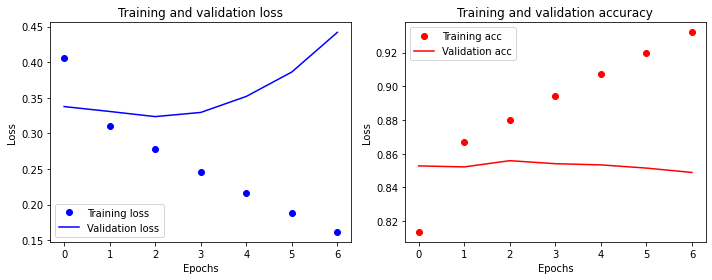

In [90]:
sp_history = train(sp_rnn, sp_dataset.X_train, sp_dataset.y_train,
                   sp_dataset.X_val, sp_dataset.y_val)
show_history_plot(sp_history)

Epoch 1/20
266/266 - 7s - loss: 0.4305 - accuracy: 0.7959 - val_loss: 0.3593 - val_accuracy: 0.8409
Epoch 2/20
266/266 - 6s - loss: 0.3429 - accuracy: 0.8476 - val_loss: 0.3509 - val_accuracy: 0.8447
Epoch 3/20
266/266 - 5s - loss: 0.3099 - accuracy: 0.8625 - val_loss: 0.3402 - val_accuracy: 0.8499
Epoch 4/20
266/266 - 5s - loss: 0.2841 - accuracy: 0.8753 - val_loss: 0.3502 - val_accuracy: 0.8506
Epoch 5/20
266/266 - 5s - loss: 0.2594 - accuracy: 0.8863 - val_loss: 0.3770 - val_accuracy: 0.8508
Epoch 6/20
266/266 - 5s - loss: 0.2389 - accuracy: 0.8965 - val_loss: 0.3750 - val_accuracy: 0.8458
Epoch 7/20
266/266 - 5s - loss: 0.2193 - accuracy: 0.9065 - val_loss: 0.3987 - val_accuracy: 0.8445
Epoch 00007: early stopping




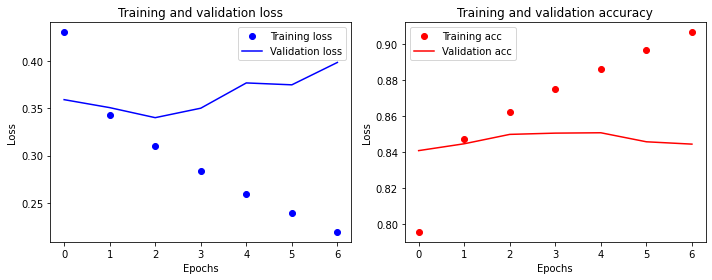

In [91]:
k_history = train(k_rnn, k_dataset.X_train, k_dataset.y_train,
                  k_dataset.X_val, k_dataset.y_val)
show_history_plot(k_history)

Epoch 1/20
266/266 - 7s - loss: 0.4058 - accuracy: 0.8115 - val_loss: 0.3396 - val_accuracy: 0.8563
Epoch 2/20
266/266 - 5s - loss: 0.3180 - accuracy: 0.8641 - val_loss: 0.3271 - val_accuracy: 0.8584
Epoch 3/20
266/266 - 5s - loss: 0.2858 - accuracy: 0.8775 - val_loss: 0.3128 - val_accuracy: 0.8651
Epoch 4/20
266/266 - 5s - loss: 0.2545 - accuracy: 0.8935 - val_loss: 0.3179 - val_accuracy: 0.8658
Epoch 5/20
266/266 - 5s - loss: 0.2275 - accuracy: 0.9058 - val_loss: 0.3371 - val_accuracy: 0.8597
Epoch 6/20
266/266 - 5s - loss: 0.2025 - accuracy: 0.9168 - val_loss: 0.3487 - val_accuracy: 0.8578
Epoch 7/20
266/266 - 5s - loss: 0.1794 - accuracy: 0.9280 - val_loss: 0.3834 - val_accuracy: 0.8601
Epoch 00007: early stopping




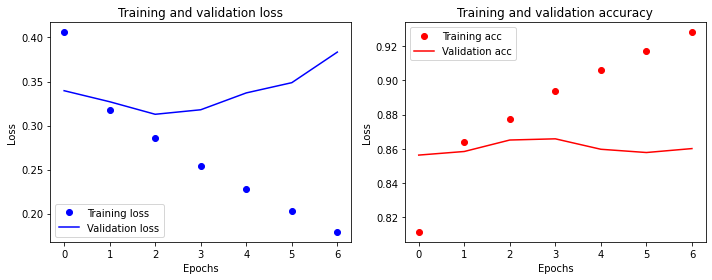

In [92]:
m_history = train(m_rnn, m_dataset.X_train, m_dataset.y_train,
                  m_dataset.X_val, m_dataset.y_val)
show_history_plot(m_history)

## STEP 7. Sentiment Analysis - 4. 모델 평가
---

### 1. 테스트셋으로 모델 평가

In [94]:
X_test_list = [sp_dataset.X_test, k_dataset.X_test, m_dataset.X_test]
y_test_list = [sp_dataset.y_test, k_dataset.y_test, m_dataset.y_test]
models = [sp_rnn, k_rnn, m_rnn]

evaluation_res = [ models[i].evaluate(X_test_list[i],
                                      y_test_list[i],
                                      verbose=2) for i in range(3)]
df = pd.DataFrame(evaluation_res, 
                  index=['sp', 'khaiii', 'mecab'],
                  columns=['loss', 'accuracy'])

1537/1537 - 3s - loss: 0.4654 - accuracy: 0.8429
1537/1537 - 2s - loss: 0.4120 - accuracy: 0.8396
1537/1537 - 2s - loss: 0.3897 - accuracy: 0.8571


In [95]:
df

,loss,accuracy
sp,0.465422,0.842891
khaiii,0.411993,0.839616
mecab,0.389723,0.857111


모든 경우에 accuary 80%가 넘는 준수한 결과를 보였다.

지표에 따라 순위를 매겨 보면 아래와 같다.
- loss : Mecab > Khaiii > SentencePiece
- accuray : Mecab > Khaiii > SentencePiece

loss와 accuracy에서 모두 Mecab가 가장 좋은 성능을 보였다.

### 2. 임의의 문장을 통한 평가
최근 개봉한 영화 서복의 관람평을 이용하여 각 모델의 성능을 확인해 보자.

In [144]:
reviews = [ "삶이란 무엇인지, 죽음이란 무엇인지영화를 보고 나서도 계속 생각하게 만드는 여운이 있는 영화.", 
 "생각이 많아지는 영화였어요.배우들 연기도 몰입도 높았고잔잔하면서 강한 ost 좋았어요.티비로도 봐야겠어요.", 
 "할 말이 없는 영화.헛웃음도 안나옴", 
 "별점을 안줄수 없어서 1점요 감동도 없고 뻔한 내용을 엄청 재미없게 풀어내네요 감독이문제인가요?"]

In [138]:
def test_review(review, sp_tokenizer, k_tokenizer, m_tokenizer,
                sp_rnn, k_rnn, m_rnn):
    encoded_sp = sp_tokenizer.encode(review)
    encoded_k = k_tokenizer.encode(review)
    encoded_m = m_tokenizer.encode(review)
    
    print(f'review : {review}')
    print(f'result - sp    : {sp_rnn.predict([encoded_sp])[0][0]}')
    print(f'result - khaiii: {k_rnn.predict([encoded_k])[0][0]}')
    print(f'result - mecab : {m_rnn.predict([encoded_m])[0][0]}')

In [145]:
for review in reviews:
    test_review(review, sp_tokenizer, k_tokenizer, m_tokenizer,
                sp_rnn, k_rnn, m_rnn)
    print()

review : 삶이란 무엇인지, 죽음이란 무엇인지영화를 보고 나서도 계속 생각하게 만드는 여운이 있는 영화.
result - sp    : 0.9999606609344482
result - khaiii: 0.9991567134857178
result - mecab : 0.9995036125183105

review : 생각이 많아지는 영화였어요.배우들 연기도 몰입도 높았고잔잔하면서 강한 ost 좋았어요.티비로도 봐야겠어요.
result - sp    : 0.9999979734420776
result - khaiii: 0.9985951781272888
result - mecab : 0.9900805354118347

review : 할 말이 없는 영화.헛웃음도 안나옴
result - sp    : 0.0014049607561901212
result - khaiii: 0.0009561166516505182
result - mecab : 9.902705642161891e-05

review : 별점을 안줄수 없어서 1점요 감동도 없고 뻔한 내용을 엄청 재미없게 풀어내네요 감독이문제인가요?
result - sp    : 0.01629416085779667
result - khaiii: 0.0027915318496525288
result - mecab : 0.0014639663277193904



첫번째와 두번째 관람평은 긍정적인 내용으로 model의 predict 결과가 1에 가깝게 나와야 하며, 세번째와 네번째 관람평은 부정적인 내용이므로 예측 결과가 0에 가깝게 나와야한다.

실험 결과 모든 모델에서 목표값과 유사한 예측결과를 얻었고, 이를 통해 모델 학습이 정상적으로 이루어졌음을 알 수 있었다.

### 3. 결론

세가지(SentencePiece-unigram, Mecab, Khaiii)의 Tokenizer를 이용하여 동일한 데이터를 토큰화하여 동일한 모델의 학습 데이터로 사용하였다. 그 결과 형태소 분석기인 Mecab가 가장 좋은 성능을 보임을 확인할 수 있었다. 

하지만, 성능의 차이가 그렇게 크지 않으므로 oov 문제가 많이 예상되는 경우 혹은 기타 다른 상황에서 SentencePiece 역시 좋은 방법론이 될 수 있을 것이라 본다.

## STEP 8. 추가실험
---

### 1. model type

In [19]:
def load_data_with_sp(train_data, test_data, model_type='unigram', num_words=10000):
    # 1. 중복 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    test_data.drop_duplicates(subset=['document'], inplace=True)
    
    # 2. 결측치 제거
    train_data = train_data.dropna(how = 'any')
    test_data = test_data.dropna(how = 'any')
    
    # 3. 토큰화
    tokenizer = SPTockenizer()
    X_train, word_index, index_word = tokenizer.tokenize(train_data['document'].to_list(), 
                                                         model_type=model_type,
                                                         vocab_size=num_words)
    X_test = [ tokenizer.encode(sen) for sen in test_data['document'].to_list() ]

    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), tokenizer

#### 1) unigram

- 토큰화

In [20]:
X_train, y_train, X_test, y_test, sp_tokenizer = load_data_with_sp(train_data,
                                                                   test_data)
unigram_dataset = Dataset(X_train, y_train, X_test, y_test, sp_tokenizer)

In [31]:
print(f'X_train[0] : {unigram_dataset.X_train[1]}')
print(f'X_train[0] - raw : {train_data.iloc[1]["document"]}')
print(f'X_train[0] - decoding : {unigram_dataset.tokenizer.decode(unigram_dataset.X_train[1])}')
for i in unigram_dataset.X_train[1]:
    print(f' >> id[{i}] : {unigram_dataset.tokenizer.index_word[i]}')

X_train[0] : [1667, 8, 4968, 158, 1481, 33, 273, 58, 180, 530, 397, 1222, 7602, 755, 440]
X_train[0] - raw : 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
X_train[0] - decoding : 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
 >> id[1667] : ▁흠
 >> id[8] : ...
 >> id[4968] : 포스터
 >> id[158] : 보고
 >> id[1481] : ▁초딩
 >> id[33] : 영화
 >> id[273] : 줄
 >> id[58] : ....
 >> id[180] : 오
 >> id[530] : 버
 >> id[397] : 연기
 >> id[1222] : 조차
 >> id[7602] : ▁가볍지
 >> id[755] : ▁않
 >> id[440] : 구나


- 문장 길이 지정

min sentence length : 1
max sentence length : 132
avg sentence length : 16


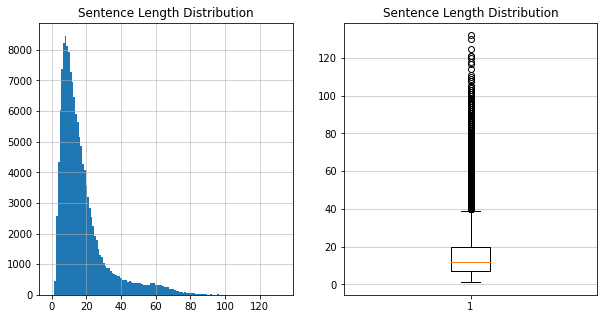

rate of sentences 45 or less in length : 0.9387133846848449
rate of sentences 47 or less in length : 0.9438166121683929
rate of sentences 49 or less in length : 0.9490771777647042
rate of sentences 51 or less in length : 0.9541940868232751
rate of sentences 53 or less in length : 0.9586200763431886


In [38]:
unigram_length_hist = check_sentence_len_distribution(unigram_dataset.X_train)

for threshold in range(45, 55, 2):
    rate_under_lenght_threshold(unigram_length_hist, threshold)

In [39]:
unigram_max_length = 50

- 패딩 추가

In [40]:
unigram_dataset.X_train = tf.keras.preprocessing.sequence.pad_sequences(
    unigram_dataset.X_train, padding='pre', maxlen=unigram_max_length)

unigram_dataset.X_test = tf.keras.preprocessing.sequence.pad_sequences(
    unigram_dataset.X_test, padding='pre', maxlen=unigram_max_length)

In [41]:
unigram_dataset.X_train[0], unigram_dataset.X_test[0] 

(array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,   61,
         870,    5,   30, 2025,   66, 1720], dtype=int32),
 array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0, 2643,  275], dtype=int32))

- validation set 분리

In [42]:
unigram_dataset.X_train, unigram_dataset.X_val, unigram_dataset.y_train, unigram_dataset.y_val = train_test_split(unigram_dataset.X_train, unigram_dataset.y_train, test_size=10000, random_state=42)
unigram_dataset.X_train.shape, unigram_dataset.X_val.shape, unigram_dataset.y_train.shape, unigram_dataset.y_val.shape

((136182, 50), (10000, 50), (136182,), (10000,))

- 모델 정의

In [49]:
unigram_rnn = get_model(vocab_size, units=128)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_4 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 1,133,889
Trainable params: 1,133,889
Non-trainable params: 0
_________________________________________________________________


- 모델 학습

Epoch 1/20
266/266 - 9s - loss: 0.4107 - accuracy: 0.8082 - val_loss: 0.3417 - val_accuracy: 0.8495
Epoch 2/20
266/266 - 6s - loss: 0.3129 - accuracy: 0.8651 - val_loss: 0.3263 - val_accuracy: 0.8578
Epoch 3/20
266/266 - 5s - loss: 0.2798 - accuracy: 0.8793 - val_loss: 0.3228 - val_accuracy: 0.8585
Epoch 4/20
266/266 - 5s - loss: 0.2466 - accuracy: 0.8938 - val_loss: 0.3474 - val_accuracy: 0.8557
Epoch 5/20
266/266 - 5s - loss: 0.2171 - accuracy: 0.9080 - val_loss: 0.3591 - val_accuracy: 0.8511
Epoch 6/20
266/266 - 5s - loss: 0.1926 - accuracy: 0.9195 - val_loss: 0.3786 - val_accuracy: 0.8464
Epoch 7/20
266/266 - 5s - loss: 0.1669 - accuracy: 0.9308 - val_loss: 0.4395 - val_accuracy: 0.8459
Epoch 00007: early stopping




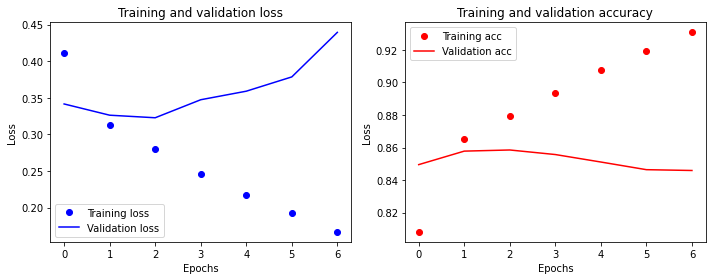

In [50]:
unigram_history = train(unigram_rnn,
                        unigram_dataset.X_train,
                        unigram_dataset.y_train,
                        unigram_dataset.X_val, 
                        unigram_dataset.y_val)
show_history_plot(unigram_history)

#### 2) bpe

- 토큰화

In [21]:
X_train, y_train, X_test, y_test, sp_tokenizer = load_data_with_sp(train_data,
                                                                   test_data,
                                                                   model_type='bpe')
bpe_dataset = Dataset(X_train, y_train, X_test, y_test, sp_tokenizer)

In [32]:
print(f'X_train[0] : {bpe_dataset.X_train[1]}')
print(f'X_train[0] - raw : {train_data.iloc[1]["document"]}')
print(f'X_train[0] - decoding : {bpe_dataset.tokenizer.decode(bpe_dataset.X_train[1])}')
for i in bpe_dataset.X_train[1]:
    print(f' >> id[{i}] : {bpe_dataset.tokenizer.index_word[i]}')

X_train[0] : [1614, 8, 4970, 162, 1290, 4, 8506, 47, 8361, 8473, 268, 1703, 1909, 8293, 66, 404]
X_train[0] - raw : 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
X_train[0] - decoding : 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
 >> id[1614] : ▁흠
 >> id[8] : ...
 >> id[4970] : 포스터
 >> id[162] : 보고
 >> id[1290] : ▁초딩
 >> id[4] : 영화
 >> id[8506] : 줄
 >> id[47] : ....
 >> id[8361] : 오
 >> id[8473] : 버
 >> id[268] : 연기
 >> id[1703] : 조차
 >> id[1909] : ▁가볍
 >> id[8293] : 지
 >> id[66] : ▁않
 >> id[404] : 구나


- 문장 길이 지정

min sentence length : 1
max sentence length : 121
avg sentence length : 16


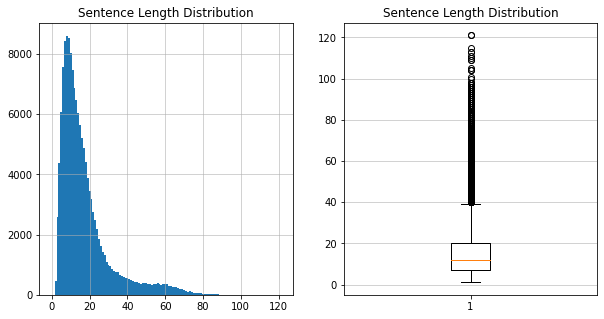

rate of sentences 45 or less in length : 0.9410255708637179
rate of sentences 47 or less in length : 0.9461151167722428
rate of sentences 49 or less in length : 0.9515124981187835
rate of sentences 51 or less in length : 0.9562942085892928
rate of sentences 53 or less in length : 0.960939103309573


In [51]:
bpe_length_hist = check_sentence_len_distribution(bpe_dataset.X_train)

for threshold in range(45, 55, 2):
    rate_under_lenght_threshold(bpe_length_hist, threshold)

In [52]:
bpe_max_length = 48

- 패딩 추가

In [53]:
bpe_dataset.X_train = tf.keras.preprocessing.sequence.pad_sequences(
    bpe_dataset.X_train, padding='pre', maxlen=bpe_max_length)

bpe_dataset.X_test = tf.keras.preprocessing.sequence.pad_sequences(
    bpe_dataset.X_test, padding='pre', maxlen=bpe_max_length)

In [54]:
bpe_dataset.X_train[0], bpe_dataset.X_test[0] 

(array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    7, 1068,    3,
          54, 2400,   38, 2095], dtype=int32),
 array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0, 1323,  454], dtype=int32))

- validation set 분리

In [55]:
bpe_dataset.X_train, bpe_dataset.X_val, bpe_dataset.y_train, bpe_dataset.y_val = train_test_split(bpe_dataset.X_train, bpe_dataset.y_train, test_size=10000, random_state=42)
bpe_dataset.X_train.shape, bpe_dataset.X_val.shape, bpe_dataset.y_train.shape, bpe_dataset.y_val.shape

((136182, 48), (10000, 48), (136182,), (10000,))

- 모델 정의

In [56]:
bpe_rnn = get_model(vocab_size, units=128)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 129       
Total params: 1,133,889
Trainable params: 1,133,889
Non-trainable params: 0
_________________________________________________________________


- 모델 학습

Epoch 1/20
266/266 - 7s - loss: 0.4059 - accuracy: 0.8109 - val_loss: 0.3371 - val_accuracy: 0.8557
Epoch 2/20
266/266 - 5s - loss: 0.3095 - accuracy: 0.8665 - val_loss: 0.3232 - val_accuracy: 0.8575
Epoch 3/20
266/266 - 5s - loss: 0.2737 - accuracy: 0.8810 - val_loss: 0.3340 - val_accuracy: 0.8585
Epoch 4/20
266/266 - 5s - loss: 0.2418 - accuracy: 0.8955 - val_loss: 0.3453 - val_accuracy: 0.8552
Epoch 5/20
266/266 - 5s - loss: 0.2123 - accuracy: 0.9094 - val_loss: 0.3637 - val_accuracy: 0.8490
Epoch 6/20
266/266 - 5s - loss: 0.1860 - accuracy: 0.9214 - val_loss: 0.4148 - val_accuracy: 0.8484
Epoch 00006: early stopping




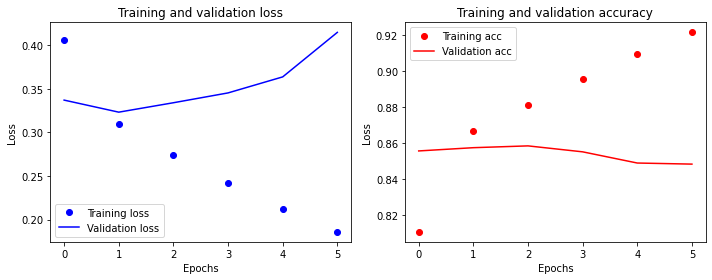

In [57]:
bpe_history = train(bpe_rnn,
                    bpe_dataset.X_train,
                    bpe_dataset.y_train,
                    bpe_dataset.X_val, 
                    bpe_dataset.y_val)
show_history_plot(bpe_history)

#### 3) char

- 토큰화

In [58]:
X_train, y_train, X_test, y_test, sp_tokenizer = load_data_with_sp(train_data,
                                                                   test_data,
                                                                   model_type='char')
char_dataset = Dataset(X_train, y_train, X_test, y_test, sp_tokenizer)

In [59]:
print(f'X_train[0] : {char_dataset.X_train[1]}')
print(f'X_train[0] - raw : {train_data.iloc[1]["document"]}')
print(f'X_train[0] - decoding : {char_dataset.tokenizer.decode(char_dataset.X_train[1])}')
for i in char_dataset.X_train[1]:
    print(f' >> id[{i}] : {char_dataset.tokenizer.index_word[i]}')

X_train[0] : [3, 722, 4, 4, 4, 205, 40, 146, 20, 8, 3, 275, 382, 11, 10, 222, 4, 4, 4, 4, 77, 189, 63, 18, 156, 251, 3, 12, 811, 9, 3, 118, 101, 17]
X_train[0] - raw : 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
X_train[0] - decoding : 흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나
 >> id[3] : ▁
 >> id[722] : 흠
 >> id[4] : .
 >> id[4] : .
 >> id[4] : .
 >> id[205] : 포
 >> id[40] : 스
 >> id[146] : 터
 >> id[20] : 보
 >> id[8] : 고
 >> id[3] : ▁
 >> id[275] : 초
 >> id[382] : 딩
 >> id[11] : 영
 >> id[10] : 화
 >> id[222] : 줄
 >> id[4] : .
 >> id[4] : .
 >> id[4] : .
 >> id[4] : .
 >> id[77] : 오
 >> id[189] : 버
 >> id[63] : 연
 >> id[18] : 기
 >> id[156] : 조
 >> id[251] : 차
 >> id[3] : ▁
 >> id[12] : 가
 >> id[811] : 볍
 >> id[9] : 지
 >> id[3] : ▁
 >> id[118] : 않
 >> id[101] : 구
 >> id[17] : 나


- 문장 길이 지정

min sentence length : 2
max sentence length : 147
avg sentence length : 36


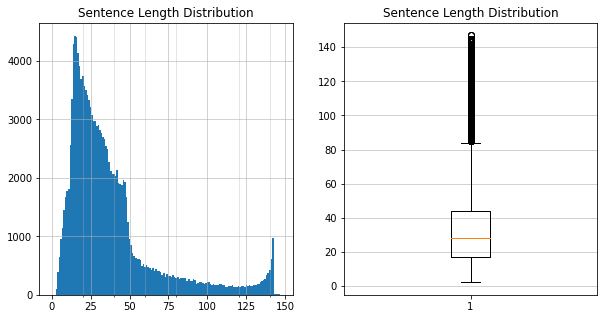

rate of sentences 80 or less in length : 0.9068695188190065
rate of sentences 82 or less in length : 0.9106319519503085
rate of sentences 84 or less in length : 0.9145175192568168
rate of sentences 86 or less in length : 0.9180884103377981
rate of sentences 88 or less in length : 0.9215224856685502
rate of sentences 90 or less in length : 0.924922357061745
rate of sentences 92 or less in length : 0.9279801890793669
rate of sentences 94 or less in length : 0.930908046134271
rate of sentences 96 or less in length : 0.933774336101572
rate of sentences 98 or less in length : 0.9364627655935751


In [63]:
char_length_hist = check_sentence_len_distribution(char_dataset.X_train)

for threshold in range(80, 100, 2):
    rate_under_lenght_threshold(char_length_hist, threshold)

In [65]:
char_max_length = 80

- 패딩 추가

In [66]:
char_dataset.X_train = tf.keras.preprocessing.sequence.pad_sequences(
    char_dataset.X_train, padding='pre', maxlen=char_max_length)

char_dataset.X_test = tf.keras.preprocessing.sequence.pad_sequences(
    char_dataset.X_test, padding='pre', maxlen=char_max_length)

char_dataset.X_train[0], char_dataset.X_test[0] 

(array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   3,  15,   3,  96, 541,
          4,   4,   3,  55,  86,   3,  86, 320,  17,  54,  33,   3, 330,
        105,  26], dtype=int32),
 array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3, 638,
          3,  24], dtype=int32))

- validation set 분리

In [67]:
char_dataset.X_train, char_dataset.X_val, char_dataset.y_train, char_dataset.y_val = train_test_split(char_dataset.X_train, char_dataset.y_train, test_size=10000, random_state=42)
char_dataset.X_train.shape, char_dataset.X_val.shape, char_dataset.y_train.shape, char_dataset.y_val.shape

((136182, 80), (10000, 80), (136182,), (10000,))

- 모델 정의

In [68]:
char_rnn = get_model(vocab_size, units=128)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, None, 100)         1000000   
_________________________________________________________________
lstm_6 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_12 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 129       
Total params: 1,133,889
Trainable params: 1,133,889
Non-trainable params: 0
_________________________________________________________________


- 모델 학습

Epoch 1/20
266/266 - 9s - loss: 0.4781 - accuracy: 0.7697 - val_loss: 0.4196 - val_accuracy: 0.8085
Epoch 2/20
266/266 - 7s - loss: 0.4089 - accuracy: 0.8110 - val_loss: 0.3955 - val_accuracy: 0.8189
Epoch 3/20
266/266 - 7s - loss: 0.3808 - accuracy: 0.8270 - val_loss: 0.3791 - val_accuracy: 0.8279
Epoch 4/20
266/266 - 7s - loss: 0.3604 - accuracy: 0.8376 - val_loss: 0.3655 - val_accuracy: 0.8359
Epoch 5/20
266/266 - 7s - loss: 0.3458 - accuracy: 0.8456 - val_loss: 0.3702 - val_accuracy: 0.8383
Epoch 6/20
266/266 - 7s - loss: 0.3334 - accuracy: 0.8517 - val_loss: 0.3578 - val_accuracy: 0.8434
Epoch 7/20
266/266 - 7s - loss: 0.3233 - accuracy: 0.8578 - val_loss: 0.3549 - val_accuracy: 0.8424
Epoch 8/20
266/266 - 7s - loss: 0.3142 - accuracy: 0.8623 - val_loss: 0.3574 - val_accuracy: 0.8416
Epoch 9/20
266/266 - 7s - loss: 0.3041 - accuracy: 0.8683 - val_loss: 0.3595 - val_accuracy: 0.8452
Epoch 10/20
266/266 - 7s - loss: 0.2947 - accuracy: 0.8731 - val_loss: 0.3572 - val_accuracy: 0.8466

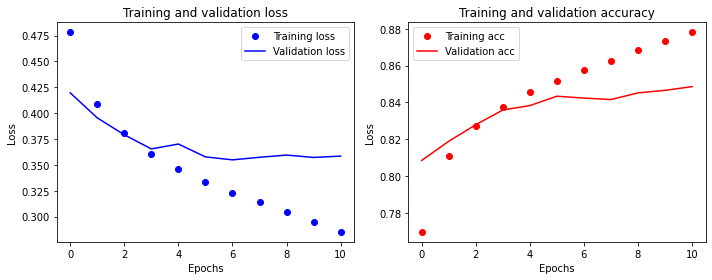

In [69]:
char_history = train(char_rnn,
                     char_dataset.X_train,
                     char_dataset.y_train,
                     char_dataset.X_val, 
                     char_dataset.y_val)
show_history_plot(char_history)

#### 4) 모델 평가

In [71]:
X_test_list = [unigram_dataset.X_test, bpe_dataset.X_test, char_dataset.X_test]
y_test_list = [unigram_dataset.y_test, bpe_dataset.y_test, char_dataset.y_test]
models = [unigram_rnn, bpe_rnn, char_rnn]

evaluation_res = [ models[i].evaluate(X_test_list[i],
                                      y_test_list[i],
                                      verbose=2) for i in range(3)]
df = pd.DataFrame(evaluation_res, 
                  index=['unigram', 'bpe', 'char'],
                  columns=['loss', 'accuracy'])

1537/1537 - 3s - loss: 0.4569 - accuracy: 0.8416
1537/1537 - 3s - loss: 0.4230 - accuracy: 0.8467
1537/1537 - 3s - loss: 0.3605 - accuracy: 0.8429


In [72]:
df

,loss,accuracy
unigram,0.456912,0.841610
bpe,0.423032,0.846675
char,0.360519,0.842850


모든 경우에 accuary 80%가 넘는 준수한 결과를 보였다.

지표에 따라 순위를 매겨 보면 아래와 같다.
- loss : char > bpe > unigram
- accuray : bpe > char > unigram

loss에서는 char 방식이, accaury에서는 bpe가 가장 좋은 성능을 보였고, 모든 지표에서 unigram이 가장 않좋은 성능을 보였다.

### 2. vocab size

#### 1) vocab_size = 5000

In [290]:
X_train, y_train, X_test, y_test, sp_tokenizer = load_data_with_sp(train_data,
                                                                   test_data,
                                                                   num_words=5000)
vs_5000_dataset = Dataset(X_train, y_train, X_test, y_test, sp_tokenizer)

In [291]:
len(vs_5000_dataset.tokenizer.word_index),  len(vs_5000_dataset.tokenizer.index_word)

(5000, 5000)

In [325]:
sentence_idx = 1519
print(f'X_train[{sentence_idx}] : {vs_5000_dataset.X_train[sentence_idx]}')
print(f'X_train[{sentence_idx}] - raw : {train_data.iloc[sentence_idx]["document"]}')
print(f'X_train[{sentence_idx}] - decoding : {vs_5000_dataset.tokenizer.decode(vs_5000_dataset.X_train[sentence_idx])}')
for i in vs_5000_dataset.X_train[sentence_idx]:
    print(f' >> id[{i}] : {vs_5000_dataset.tokenizer.index_word[i]}')

X_train[1519] : [3, 2140, 1054, 1100, 239, 0, 569]
X_train[1519] - raw : 픽션이지만 재미뚬ㅎㅎ
X_train[1519] - decoding : 픽션이지만 재미 ⁇ ᄒᄒ
 >> id[3] : ▁
 >> id[2140] : 픽
 >> id[1054] : 션
 >> id[1100] : 이지만
 >> id[239] : ▁재미
 >> id[0] : <unk>
 >> id[569] : ᄒᄒ


- 문장 길이 지정

min sentence length : 1
max sentence length : 134
avg sentence length : 19


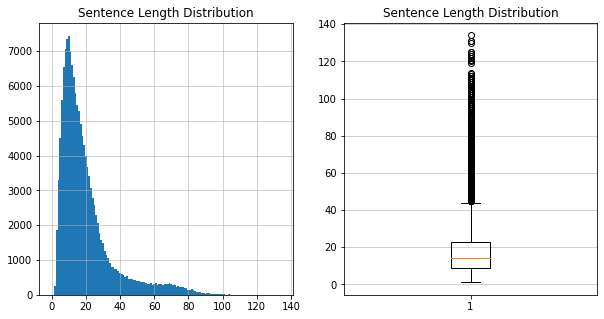

rate of sentences 50 or less in length : 0.9343626438275574
rate of sentences 52 or less in length : 0.9394863936736397
rate of sentences 54 or less in length : 0.9442749449316605
rate of sentences 56 or less in length : 0.9484957108262303
rate of sentences 58 or less in length : 0.9526617504207084


In [327]:
vs_5000_length_hist = check_sentence_len_distribution(vs_5000_dataset.X_train)

for threshold in range(50, 60, 2):
    rate_under_lenght_threshold(vs_5000_length_hist, threshold)

In [328]:
vs_5000_max_length = 57

- 패딩 추가

In [329]:
vs_5000_dataset.X_train = tf.keras.preprocessing.sequence.pad_sequences(
    vs_5000_dataset.X_train, padding='pre', maxlen=vs_5000_max_length)

vs_5000_dataset.X_test = tf.keras.preprocessing.sequence.pad_sequences(
    vs_5000_dataset.X_test, padding='pre', maxlen=vs_5000_max_length)

- validation set 분리

In [330]:
vs_5000_dataset.X_train, vs_5000_dataset.X_val, vs_5000_dataset.y_train, vs_5000_dataset.y_val = train_test_split(vs_5000_dataset.X_train, vs_5000_dataset.y_train, test_size=10000, random_state=42)
vs_5000_dataset.X_train.shape, vs_5000_dataset.X_val.shape, vs_5000_dataset.y_train.shape, vs_5000_dataset.y_val.shape

((136182, 57), (10000, 57), (136182,), (10000,))

- 모델 정의

In [331]:
vs_5000_rnn = get_model(5000, units=128)

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, None, 100)         500000    
_________________________________________________________________
lstm_10 (LSTM)               (None, 128)               117248    
_________________________________________________________________
dense_20 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 129       
Total params: 633,889
Trainable params: 633,889
Non-trainable params: 0
_________________________________________________________________


- 모델 학습

Epoch 1/20
266/266 - 7s - loss: 0.4129 - accuracy: 0.8073 - val_loss: 0.3496 - val_accuracy: 0.8483
Epoch 2/20
266/266 - 5s - loss: 0.3341 - accuracy: 0.8540 - val_loss: 0.3412 - val_accuracy: 0.8503
Epoch 3/20
266/266 - 5s - loss: 0.3081 - accuracy: 0.8653 - val_loss: 0.3298 - val_accuracy: 0.8525
Epoch 4/20
266/266 - 5s - loss: 0.2853 - accuracy: 0.8757 - val_loss: 0.3251 - val_accuracy: 0.8540
Epoch 5/20
266/266 - 5s - loss: 0.2663 - accuracy: 0.8853 - val_loss: 0.3346 - val_accuracy: 0.8567
Epoch 6/20
266/266 - 5s - loss: 0.2485 - accuracy: 0.8937 - val_loss: 0.3357 - val_accuracy: 0.8585
Epoch 7/20
266/266 - 5s - loss: 0.2320 - accuracy: 0.9017 - val_loss: 0.3532 - val_accuracy: 0.8575
Epoch 8/20
266/266 - 5s - loss: 0.2149 - accuracy: 0.9094 - val_loss: 0.3652 - val_accuracy: 0.8542
Epoch 00008: early stopping




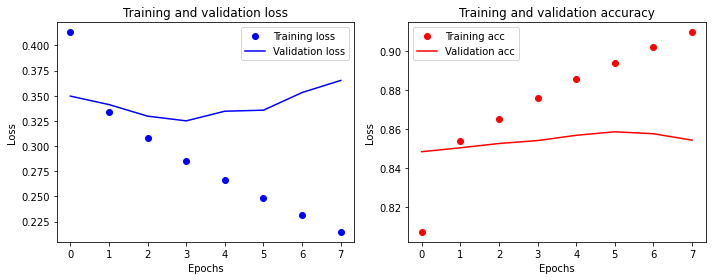

In [332]:
vs_5000__history = train(vs_5000_rnn,
                        vs_5000_dataset.X_train,
                        vs_5000_dataset.y_train,
                        vs_5000_dataset.X_val, 
                        vs_5000_dataset.y_val)
show_history_plot(vs_5000__history)

#### 2) vocab_size = 10000

In [288]:
X_train, y_train, X_test, y_test, sp_tokenizer = load_data_with_sp(train_data,
                                                                   test_data,
                                                                   num_words=10000)
vs_10000_dataset = Dataset(X_train, y_train, X_test, y_test, sp_tokenizer)

In [289]:
len(vs_10000_dataset.tokenizer.word_index),  len(vs_10000_dataset.tokenizer.index_word)

(10000, 10000)

In [326]:
sentence_idx = 1519
print(f'X_train[{sentence_idx}] : {vs_10000_dataset.X_train[sentence_idx]}')
print(f'X_train[{sentence_idx}] - raw : {train_data.iloc[sentence_idx]["document"]}')
print(f'X_train[{sentence_idx}] - decoding : {vs_10000_dataset.tokenizer.decode(vs_10000_dataset.X_train[sentence_idx])}')
for i in vs_10000_dataset.X_train[sentence_idx]:
    print(f' >> id[{i}] : {vs_10000_dataset.tokenizer.index_word[i]}')

X_train[1519] : [7609, 834, 196, 0, 499]
X_train[1519] - raw : 픽션이지만 재미뚬ㅎㅎ
X_train[1519] - decoding : 픽션이지만 재미 ⁇ ᄒᄒ
 >> id[7609] : ▁픽션
 >> id[834] : 이지만
 >> id[196] : ▁재미
 >> id[0] : <unk>
 >> id[499] : ᄒᄒ


- 문장 길이 지정

min sentence length : 1
max sentence length : 132
avg sentence length : 16


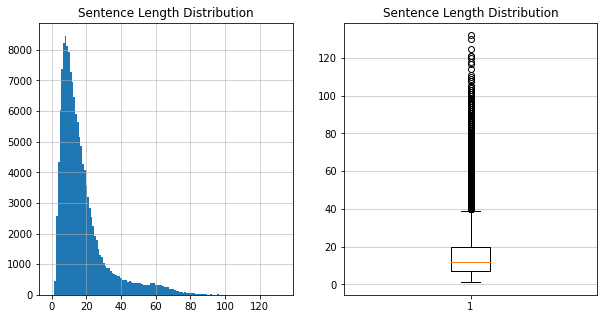

rate of sentences 45 or less in length : 0.9387133846848449
rate of sentences 47 or less in length : 0.9438166121683929
rate of sentences 49 or less in length : 0.9490771777647042
rate of sentences 51 or less in length : 0.9541940868232751
rate of sentences 53 or less in length : 0.9586200763431886


In [333]:
vs_10000_length_hist = check_sentence_len_distribution(vs_10000_dataset.X_train)

for threshold in range(45, 55, 2):
    rate_under_lenght_threshold(vs_10000_length_hist, threshold)

In [334]:
vs_10000_max_length = 50

- 패딩 추가

In [335]:
vs_10000_dataset.X_train = tf.keras.preprocessing.sequence.pad_sequences(
    vs_10000_dataset.X_train, padding='pre', maxlen=vs_10000_max_length)

vs_10000_dataset.X_test = tf.keras.preprocessing.sequence.pad_sequences(
    vs_10000_dataset.X_test, padding='pre', maxlen=vs_10000_max_length)

- validation set 분리

In [336]:
vs_10000_dataset.X_train, vs_10000_dataset.X_val, vs_10000_dataset.y_train, vs_10000_dataset.y_val = train_test_split(vs_10000_dataset.X_train, vs_10000_dataset.y_train, test_size=10000, random_state=42)
vs_10000_dataset.X_train.shape, vs_10000_dataset.X_val.shape, vs_10000_dataset.y_train.shape, vs_10000_dataset.y_val.shape

((136182, 50), (10000, 50), (136182,), (10000,))

- 모델 정의

In [337]:
vs_10000_rnn = get_model(10000, units=128)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, None, 100)         1000000   
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               117248    
_________________________________________________________________
dense_22 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 129       
Total params: 1,133,889
Trainable params: 1,133,889
Non-trainable params: 0
_________________________________________________________________


- 모델 학습

Epoch 1/20
266/266 - 7s - loss: 0.4112 - accuracy: 0.8075 - val_loss: 0.3373 - val_accuracy: 0.8537
Epoch 2/20
266/266 - 5s - loss: 0.3102 - accuracy: 0.8669 - val_loss: 0.3261 - val_accuracy: 0.8558
Epoch 3/20
266/266 - 5s - loss: 0.2770 - accuracy: 0.8802 - val_loss: 0.3212 - val_accuracy: 0.8587
Epoch 4/20
266/266 - 5s - loss: 0.2443 - accuracy: 0.8945 - val_loss: 0.3324 - val_accuracy: 0.8570
Epoch 5/20
266/266 - 5s - loss: 0.2156 - accuracy: 0.9081 - val_loss: 0.3752 - val_accuracy: 0.8526
Epoch 6/20
266/266 - 5s - loss: 0.1872 - accuracy: 0.9207 - val_loss: 0.3966 - val_accuracy: 0.8486
Epoch 7/20
266/266 - 5s - loss: 0.1643 - accuracy: 0.9312 - val_loss: 0.4561 - val_accuracy: 0.8496
Epoch 00007: early stopping




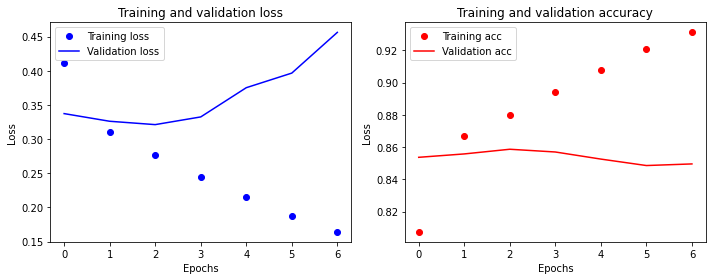

In [338]:
vs_10000_history = train(vs_10000_rnn,
                        vs_10000_dataset.X_train,
                        vs_10000_dataset.y_train,
                        vs_10000_dataset.X_val, 
                        vs_10000_dataset.y_val)
show_history_plot(vs_10000_history)

#### 3) vocab_size = 100000

In [284]:
X_train, y_train, X_test, y_test, sp_tokenizer = load_data_with_sp(train_data,
                                                                   test_data,
                                                                   num_words=100000)
vs_100000_dataset = Dataset(X_train, y_train, X_test, y_test, sp_tokenizer)

In [285]:
len(vs_100000_dataset.tokenizer.word_index),  len(vs_100000_dataset.tokenizer.index_word)

(100000, 100000)

In [324]:
sentence_idx = 1519
print(f'X_train[{sentence_idx}] : {vs_100000_dataset.X_train[sentence_idx]}')
print(f'X_train[{sentence_idx}] - raw : {train_data.iloc[sentence_idx]["document"]}')
print(f'X_train[{sentence_idx}] - decoding : {vs_100000_dataset.tokenizer.decode(vs_100000_dataset.X_train[sentence_idx])}')
for i in vs_100000_dataset.X_train[sentence_idx]:
    print(f' >> id[{i}] : {vs_100000_dataset.tokenizer.index_word[i]}')

X_train[1519] : [14970, 115, 133, 0, 290]
X_train[1519] - raw : 픽션이지만 재미뚬ㅎㅎ
X_train[1519] - decoding : 픽션이지만 재미 ⁇ ᄒᄒ
 >> id[14970] : ▁픽션이
 >> id[115] : 지만
 >> id[133] : ▁재미
 >> id[0] : <unk>
 >> id[290] : ᄒᄒ


- 문장 길이 지정

min sentence length : 1
max sentence length : 93
avg sentence length : 12


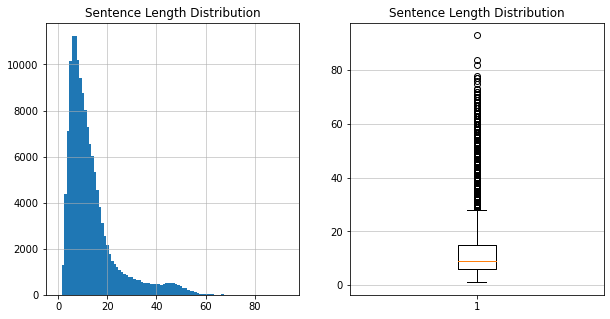

rate of sentences 30 or less in length : 0.9240056915352095
rate of sentences 32 or less in length : 0.9330218494753116
rate of sentences 34 or less in length : 0.9403962184126636
rate of sentences 36 or less in length : 0.9473601400993282
rate of sentences 38 or less in length : 0.9537083909099615


In [340]:
vs_100000_length_hist = check_sentence_len_distribution(vs_100000_dataset.X_train)

for threshold in range(30, 40, 2):
    rate_under_lenght_threshold(vs_100000_length_hist, threshold)

In [342]:
vs_100000_max_length = 37

- 패딩 추가

In [343]:
vs_100000_dataset.X_train = tf.keras.preprocessing.sequence.pad_sequences(
    vs_100000_dataset.X_train, padding='pre', maxlen=vs_100000_max_length)

vs_100000_dataset.X_test = tf.keras.preprocessing.sequence.pad_sequences(
    vs_100000_dataset.X_test, padding='pre', maxlen=vs_100000_max_length)

- validation set 분리

In [344]:
vs_100000_dataset.X_train, vs_100000_dataset.X_val, vs_100000_dataset.y_train, vs_100000_dataset.y_val = train_test_split(vs_100000_dataset.X_train, vs_20000_dataset.y_train, test_size=10000, random_state=42)
vs_100000_dataset.X_train.shape, vs_100000_dataset.X_val.shape, vs_100000_dataset.y_train.shape, vs_100000_dataset.y_val.shape

((136182, 37), (10000, 37), (136182,), (10000,))

- 모델 정의

In [345]:
vs_100000_rnn = get_model(100000, units=128)

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 100)         10000000  
_________________________________________________________________
lstm_12 (LSTM)               (None, 128)               117248    
_________________________________________________________________
dense_24 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 129       
Total params: 10,133,889
Trainable params: 10,133,889
Non-trainable params: 0
_________________________________________________________________


- 모델 학습

Epoch 1/20
266/266 - 25s - loss: 0.4201 - accuracy: 0.8023 - val_loss: 0.3493 - val_accuracy: 0.8479
Epoch 2/20
266/266 - 22s - loss: 0.2264 - accuracy: 0.9111 - val_loss: 0.3691 - val_accuracy: 0.8462
Epoch 3/20
266/266 - 22s - loss: 0.1414 - accuracy: 0.9476 - val_loss: 0.4508 - val_accuracy: 0.8391
Epoch 4/20
266/266 - 23s - loss: 0.0853 - accuracy: 0.9687 - val_loss: 0.6017 - val_accuracy: 0.8325
Epoch 5/20
266/266 - 22s - loss: 0.0532 - accuracy: 0.9804 - val_loss: 0.7924 - val_accuracy: 0.8302
Epoch 00005: early stopping




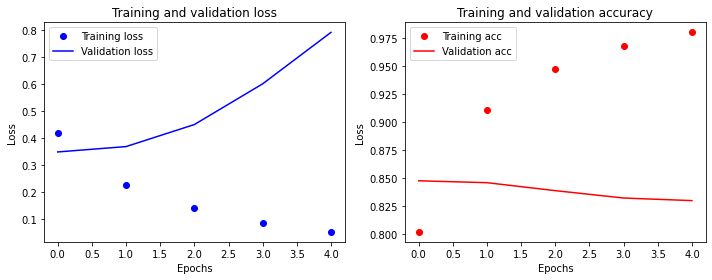

In [346]:
vs_100000_history = train(vs_100000_rnn,
                          vs_100000_dataset.X_train,
                          vs_100000_dataset.y_train,
                          vs_100000_dataset.X_val, 
                          vs_100000_dataset.y_val)
show_history_plot(vs_100000_history)

#### 4) 모델평가

In [348]:
X_test_list = [vs_5000_dataset.X_test, vs_10000_dataset.X_test, vs_100000_dataset.X_test]
y_test_list = [vs_5000_dataset.y_test, vs_10000_dataset.y_test, vs_100000_dataset.y_test]
models = [vs_5000_rnn, vs_10000_rnn, vs_100000_rnn]

evaluation_res = [ models[i].evaluate(X_test_list[i],
                                      y_test_list[i],
                                      verbose=2) for i in range(3)]
df = pd.DataFrame(evaluation_res, 
                  index=['5000', '10000', '100000'],
                  columns=['loss', 'accuracy'])

1537/1537 - 3s - loss: 0.3788 - accuracy: 0.8466
1537/1537 - 3s - loss: 0.4690 - accuracy: 0.8479
1537/1537 - 3s - loss: 0.8192 - accuracy: 0.8327


In [355]:
df

,loss,accuracy
5000,0.378827,0.846594
10000,0.469029,0.847936
100000,0.819234,0.832740


모든 경우에 accuary 80%가 넘는 준수한 결과를 보였다.

지표에 따라 순위를 매겨 보면 아래와 같다.
- loss : 5000 > 10000 > 100000
- accuray : 10000 > 5000 > 100000

loss는 단어사전의 크기가 클수록 증가하였다. accaury는 단어 사전의 크기가 10000일 때 가장 높았다.

단어 사전 크기에 따른 차이를 가장 크게 느낄 수 있었던 때는, 인코딩 결과를 index_word와 매치하여 단어사전의 구성을 확인하였을 때였다. 같은 SentencePiece를 사용하여도 단어장의 크기에 따라 단어사전의 구성이 달라지는 것을 볼 수 있다.

![decodeing](https://ifh.cc/g/tclDIT.png)

## STEP 3. 결론
---

### 프로젝트 평가
1. SentencePiece를 이용하여 모델을 만들기까지의 과정이 정상적으로 진행되었는가?<br>코퍼스 분석, 전처리, SentencePiece 적용, 토크나이저 구현 및 동작이 빠짐없이 진행되었는가?
    - 각 동작들은 각각 아래와 같은 소제목 아래 진행되었다.
        - 코퍼스 분석 : 데이터 분석 및 가공
        - 전처리 : 데이터 로더 정의 
        - SentencePiece 적용: SPTockenizer.train
        - 토크나이저 구현 : Tokenizer 함수 정의 - SPTockenizer.tokenize /  KhaiiiTocknizer.tokenize / MecabTockenizer.tokenize
2. SentencePiece를 통해 만든 Tokenizer가 자연어처리 모델과 결합하여 동작하는가?<br>SentencePiece 토크나이저가 적용된 Text Classifier 모델이 정상적으로 수렴하여 80% 이상의 test accuracy가 확인되었다.
    - SentencePiece 토크나이저를 적용하여 데이터 로더를 구성하였다.
    - 데이터 로더를 통해 불러들인 데이터를 LSTM 모델의 input으로 사용하였다.
    - 위의 모델의 학습이 종료된 후, test dataset을 이용하여 evaluation을 진행하였고, 모든 모델이 80% 이상의 accuarcy를 기록하였다.
3. SentencePiece의 성능을 다각도로 비교분석하였는가?<br>SentencePiece 토크나이저를 활용했을 때의 성능을 다른 토크나이저 혹은 SentencePiece의 다른 옵션의 경우와 비교하여 분석을 체계적으로 진행하였다.
    - 본 프로젝트에서 세가지 방면에서 SentencePiece의 성능을 비교해 보았다.
        1. 다른 토크나이저와의 성능 비교 : SentencePiece와 더불어 Khaiii, Mecab를 사용하여 동일한 작업을 수행하였다. 네이버 영화리뷰 데이터를 이용한 감정분석 문제에 대해서는 Mecab가 가장 좋은 성능을 보였다.
        2. SentencePiece 모델 별 성능 비교 :  SentencePiece의 모델 중 unigram, bpe, char를 사용하여 동일한 작업을 수행하였다. 테스트 결과, bpe > char > unigram 순으로 좋을 성능을 보였다.
        3.  SentencePiece의 단어 사전 크기에 따른 성능 비교 : SentencePiece의 단어 사전 크기를 제한하며 사전 크기에 따른 성능 차이를 확인해 보았다. 사용된 단어 사전의 크기는 5000, 10000, 100000이고 확인 결과, 10000 > 5000 > 100000 순으로 좋은 성능을 보였다.

### 회고
- 많이 어렵지는 않지는 할 일이 많다고 생각되었던 과제다.
- 토크나이저에 대해서 집고 넘어갈 수 있는 좋은 기회였다.

## ref
---
- [02) 센텐스피스(SentencePiece)](https://wikidocs.net/86657)
- [konlpy.tag.mecab](https://konlpy-ko.readthedocs.io/ko/v0.4.3/api/konlpy.tag/#mecab-class)
- [Tokenizer 비교 실험(형태소분석, word piece)](https://i-am-wendy.tistory.com/27)
- [kakao/khaiii](https://ss37g.app.goo.gl/RHMD)
- [6) 네이버 영화 리뷰 감성 분류하기(Naver Movie Review Sentiment Analysis)
](https://wikidocs.net/44249)
- [22. 자연어 처리하기 1](https://codetorial.net/tensorflow/natural_language_processing_in_tensorflow_01.html)
- [TIL 191125 & before (2)-케라스 창시자에게 배우는 딥러닝-케라스 모델 구현하기](https://velog.io/@lostin185/TIL-191125-before-2)
- [SentencePiece Tokenizer](https://donghwa-kim.github.io/SPM.html)
- [한국어 형태소 분석기 성능 비교](https://iostream.tistory.com/144)
- [형태소 분석기 성능 비교](https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/05/10/postag/)
-[ google/sentencepiece](https://github.com/google/sentencepiece)
- [NLP - 2. 텍스트 토큰화(Text Tokenization)](https://bkshin.tistory.com/entry/NLP-2-%ED%85%8D%EC%8A%A4%ED%8A%B8-%ED%86%A0%ED%81%B0%ED%99%94Text-Tokenization)
- [병렬 코퍼스 필터링과 한국어에 최적화된 서브 워드 분절 기법을 이용한 기계번역](http://hiai.co.kr/wp-content/uploads/2019/12/%EB%85%BC%EB%AC%B8%EC%A6%9D%EB%B9%99_2019_06.pdf)
- [Subword Regularization(논문 읽기)](https://an-seunghwan.github.io/nlp/Subword-Regularization(%EB%85%BC%EB%AC%B8-%EC%9D%BD%EA%B8%B0)/)
- [3 subword algorithms help to improve your NLP model performance](https://medium.com/@makcedward/how-subword-helps-on-your-nlp-model-83dd1b836f46)
- [한국어 자연어처리 1편_서브워드 구축(Subword Tokenizer, Mecab, huggingface VS SentencePiece)](https://keep-steady.tistory.com/37)